In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from sklearn.preprocessing import StandardScaler
from scipy.linalg import qr
from sklearn.decomposition import PCA
from umap import UMAP
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.cluster import adjusted_rand_score
from scipy.spatial.distance import pdist, cdist, squareform
import matplotlib as mpl
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [22]:
# read in Janssen df

dft = pd.read_csv('primary_sulfonamides_DFT.csv')

In [8]:
info = dft[['smiles', 'rdmol', 'inchi']]
df = dft.drop(info.columns, axis=1)

In [9]:
# remove non-numerical descriptors

df_object = df.select_dtypes(include='object').columns
df = df.select_dtypes(exclude='object')
print('Non-numerical features: ')
print(str(list(df_object)))

Non-numerical features: 
['min_can', 'max_can', 'C_can', 'C_labels', 'S_can', 'S_labels', 'O1_can', 'O1_labels', 'O2_can', 'O2_labels', 'N_can', 'N_labels']


In [10]:
# standardize descriptors

scaler = StandardScaler().fit(df)
df = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)
print('Numerical features: ' + str(df.shape[1]))

Numerical features: 136


In [11]:
# drop linearly dependent columns

tol = 1e-8
q, r, p = qr(df, pivoting=True)
rank = sum(np.abs(np.diag(r)) > tol)
col_ind_to_keep = p[:rank]
col_ind_to_drop = p[rank:]
lin_dep = df[df.columns[col_ind_to_drop]].columns
df = df[df.columns[col_ind_to_keep]]

print('Linearly dependent columns: ')
print(lin_dep)
print('Non-linearly dependent features: ' + str(df.shape[1]))

Linearly dependent columns: 
Index(['H', 'O1_NPA_total', 'O2_NPA_charge', 'S_NPA_total',
       'S_ES_root_NPA_total', 'O1_ES_root_NPA_total', 'N_NPA_charge',
       'O2_ES_root_NPA_total', 'N_ES_root_NPA_charge', 'C_ES_root_NPA_total',
       'C_NPA_total', 'hardness', 'electronegativity', 'S_NPA_charge',
       'S_NPA_Rydberg', 'converged', 'multiplicity', 'charge', 'min_NPA_core',
       'min_ES_root_NPA_core'],
      dtype='object')
Non-linearly dependent features: 116


In [12]:
# drop highly correlated columns

df_corr = df.corr().abs()
upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
df = df.drop(to_drop, axis=1)

print('Highly correlated columns (>95%): ')
print(to_drop)
print('Uncorrelated columns: ' + str(df.shape[1]))

Highly correlated columns (>95%): 
['O2_NPA_core', 'O1_ES_root_NPA_core', 'E_scf', 'S_ES_root_NPA_core', 'max_NPA_valence', 'electronic_spatial_extent', 'C_NPA_charge', 'N_ES_root_NPA_total', 'C_NPA_core', 'min_ES_root_NPA_total', 'max_NPA_total', 'C_ES_root_Mulliken_charge', 'N_ES_root_Mulliken_charge', 'S_ES_root_NPA_Rydberg', 'min_NPA_total', 'number_of_atoms', 'E_thermal_correction', 'N_Mulliken_charge', 'S_ES_root_NPA_charge', 'max_ES_root_NPA_total', 'zero_point_correction', 'O1_NPA_charge', 'O2_NPA_valence', 'N_NPA_valence', 'O1_ES_root_NPA_valence', 'O2_ES_root_NPA_valence', 'N_ES_root_NPA_valence', 'S_NPA_valence', 'S_ES_root_NPA_valence', 'E', 'C_ES_root_NPA_valence', 'C_NPA_valence', 'H_thermal_correction', 'max_ES_root_NPA_core', 'G', 'E_zpe']
Uncorrelated columns: 80


/var/folders/_7/9sd8g_d51p323k3f1njm9pnc0000gn/T/ipykernel_5271/3981937023.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))


In [14]:
nneigh = 8

# create dimensionality reductions for clusterings

dfs = {}

umap_ = UMAP(n_components=2, n_neighbors=nneigh, random_state=0).fit(df)

dfs['umap2'] = pd.DataFrame(umap_.transform(df),
                        index=df.index,
                        columns=[f"UMAP{i}" for i in range(1, 3)])

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


/Users/shivaani1995/opt/anaconda3/envs/cel/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, '2D UMAP Projection')

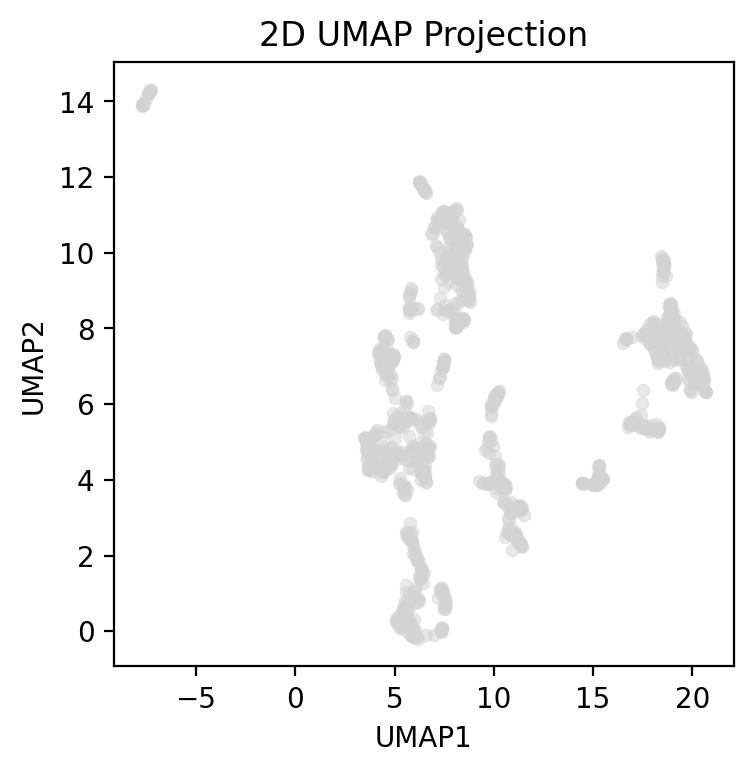

In [15]:
f = plt.figure(figsize=(4, 4), dpi=200)
color_threshold=0

sns.scatterplot("UMAP1", "UMAP2", data=dfs['umap2'], s=20, alpha=0.5, color='#d3d3d3', edgecolor='face').set_title("2D UMAP Projection")

#plt.legend(bbox_to_anchor=(1.05, 0.75), loc='upper left', borderaxespad=0)

/Users/shivaani1995/opt/anaconda3/envs/cel/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/shivaani1995/opt/anaconda3/envs/cel/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/shivaani1995/opt/anaconda3/envs/cel/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/shivaani1995/opt/anaconda3/envs/cel/lib/python3.8/site-packages/sklearn/cluster/_kme

Optimal number of clusters: 6


<AxesSubplot:xlabel='number of clusters', ylabel='silhouette score'>

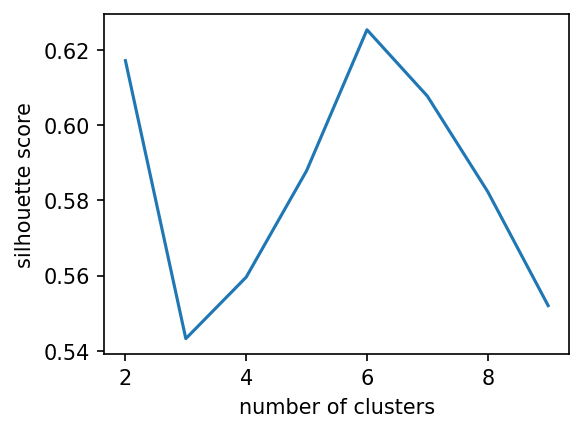

In [17]:
# silhouette scores

scores = {}

for n in range(2,10):
    cls=KMeans(n_clusters=n, random_state=0).fit(dfs['umap2']).labels_
    scores[n] = silhouette_score(dfs['umap2'], cls)
scores = pd.DataFrame(scores.values(), scores.keys()).rename(columns={0:'silhouette score'})


print(f'Optimal number of clusters: {scores.idxmax()[0]}')


scores = scores.reset_index().rename(columns={'index':'number of clusters'})
fig = plt.figure(figsize=(4,3),dpi=150)
sns.lineplot(x=scores['number of clusters'], y=scores['silhouette score'])

In [18]:
# compute linkages - this is the Agglomerative Hierarchical Clustering

NCLS = scores['number of clusters'].loc[scores['silhouette score'].idxmax()]

Z={}
cls = {}

Z['umap2'] = linkage(dfs['umap2'], method="ward")
cls['umap2'] = fcluster(Z['umap2'], NCLS, criterion='maxclust')

cls_df = pd.DataFrame(cls)

In [19]:
# combine all dfs into one

reduced_df = pd.merge(left=info, right=cls_df, left_index=True, right_index=True)
reduced_df = pd.merge(left=reduced_df, right=dfs['umap2'], left_index=True, right_index=True)

In [20]:
reduced_df

,smiles,rdmol,inchi,umap2,UMAP1,UMAP2
0,BrC1(CC1)S(=O)(=O)N,<rdkit.Chem.rdchem.Mol object at 0x1a1e603ad0>,"InChI=1S/C3H6BrNO2S/c4-3(1-2-3)8(5,6)7/h1-2H2,...",2,5.780085,7.782538
1,BrCCCS(=O)(=O)N,<rdkit.Chem.rdchem.Mol object at 0x1a1e603670>,"InChI=1S/C3H8BrNO2S/c4-2-1-3-8(5,6)7/h1-3H2,(H...",1,17.783232,7.828997
2,BrCS(=O)(=O)N,<rdkit.Chem.rdchem.Mol object at 0x1a1e702800>,"InChI=1S/CH4BrNO2S/c2-1-6(3,4)5/h1H2,(H2,3,4,5)",1,17.491390,7.854718
3,BrCc1ccc(c(c1)F)S(=O)(=O)N,<rdkit.Chem.rdchem.Mol object at 0x1a1e702260>,InChI=1S/C7H7BrFNO2S/c8-4-5-1-2-7(6(9)3-5)13(1...,2,4.666854,7.720281
4,BrCc1ccccc1S(=O)(=O)N,<rdkit.Chem.rdchem.Mol object at 0x1a1e702e40>,"InChI=1S/C7H8BrNO2S/c8-5-6-3-1-2-4-7(6)12(9,10...",2,4.857657,7.117027
...,...,...,...,...,...,...
966,[O-][N+](=O)c1cccc(c1S(=O)(=O)N)F,<rdkit.Chem.rdchem.Mol object at 0x1a1e317b20>,InChI=1S/C6H5FN2O4S/c7-4-2-1-3-5(9(10)11)6(4)1...,2,6.717780,5.548363
967,[O-][N+](=O)c1ccnc(c1)S(=O)(=O)N,<rdkit.Chem.rdchem.Mol object at 0x1a1e4198f0>,"InChI=1S/C5H5N3O4S/c6-13(11,12)5-3-4(8(9)10)1-...",4,10.486794,3.892437
968,[O-][N+](=O)c1csc(c1)S(=O)(=O)N,<rdkit.Chem.rdchem.Mol object at 0x1a1e419760>,"InChI=1S/C4H4N2O4S2/c5-12(9,10)4-1-3(2-11-4)6(...",3,6.169272,0.851052
969,[O-][N+](=O)c1ncccc1S(=O)(=O)N,<rdkit.Chem.rdchem.Mol object at 0x1a1e419490>,"InChI=1S/C5H5N3O4S/c6-13(11,12)4-2-1-3-7-5(4)8...",2,6.665994,4.828003


In [23]:
# read in training and validation set molecules to flag them in the clustered df

smiles = pd.read_csv('scope_smiles.csv')
smiles['inchi'] = smiles['smiles'].map(Chem.MolFromSmiles).map(Chem.MolToInchi)

[11:05:34] WARNING: Charges were rearranged

[11:05:34] WARNING: Charges were rearranged

[11:05:34] WARNING: Charges were rearranged



In [24]:
merged = pd.merge(left=reduced_df, right=smiles.drop('smiles', axis=1), on='inchi', how='outer')

In [26]:
to_download = merged.loc[merged['umap2'].dropna().index]
to_download = to_download.rename(columns={'umap2': 'Cluster'})
to_download['Cluster'] = to_download['Cluster'].map(int)

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

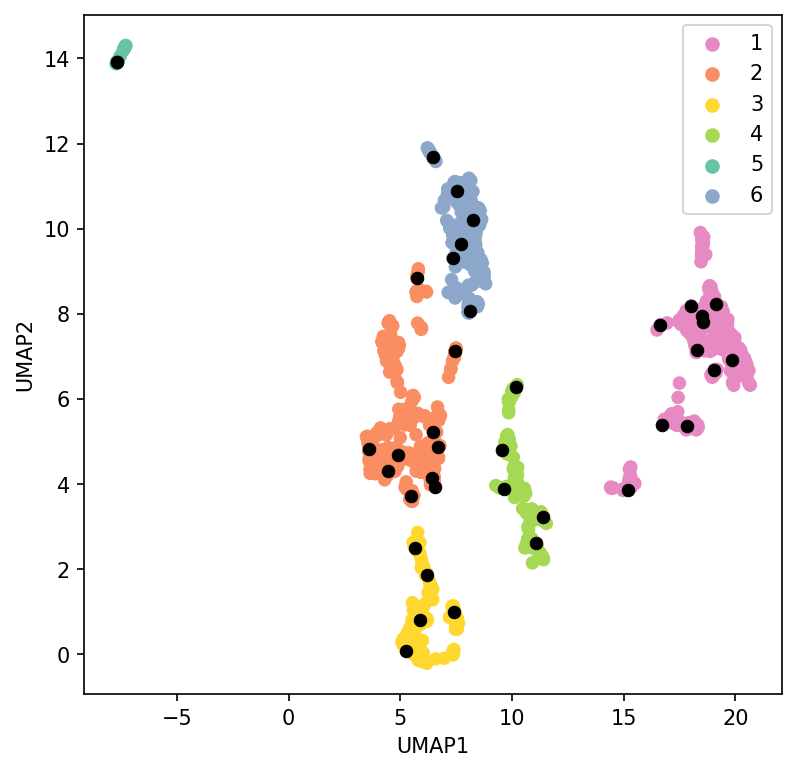

In [27]:
pal = {
      1: '#e789c3',
      2: '#fb8d62',
      3: '#ffd82f',
      4: '#a5d953',
      5: '#67c2a6',
      6: '#8da7cb', 7:'#555555'
      }

fig = plt.figure(figsize=(6,6), dpi=150)
sns.scatterplot(data=to_download, x='UMAP1', y='UMAP2', hue='Cluster', palette=pal, edgecolor='face')
sns.scatterplot(data=to_download[to_download['type']=='training'], x='UMAP1', y='UMAP2', color='black',edgecolor='face')
sns.scatterplot(data=to_download[to_download['type']=='validation'], x='UMAP1', y='UMAP2', color='black',edgecolor='face')